https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24 참조

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import json

In [3]:
# from keras import backend as K
# from keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
# from keras.optimizers import Adam, SGD
# from keras.models import Model, Sequential
# from keras.utils import plot_model
# from keras.preprocessing.image import ImageDataGenerator

# import numpy as np
# import random
# import matplotlib.pyplot as plt
# import os
# import cv2
# import json

In [4]:
tf.__version__

'2.1.0'

# 1. Define loss & base network
- 두 가지 loss 함수
    - `triplet_loss`
        - 출처: https://thelonenutblog.wordpress.com/2017/12/18/what-siamese-dreams-are-made-of/
    - `lossless_triplet_loss`
        - 출처: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [5]:
def triplet_loss(y_true, y_pred, N=128, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, not used in this function.
    y_pred -- python list containing three objects:
            anchor:   the encodings for the anchor data
            positive: the encodings for the positive data (similar to anchor)
            negative: the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)))

    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)))

    # compute loss
    basic_loss = pos_dist-neg_dist + alpha

    loss = tf.maximum(basic_loss,0.0)

    return loss

In [6]:
def lossless_triplet_loss(y_true, y_pred, N=128, beta=128, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    
    return loss

In [7]:
def cnn_base_network(in_dims, out_dims):
    model = Sequential()

    model.add(Conv2D(input_shape = in_dims,
                     filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu'))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    #1차원화

    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(out_dims, activation = 'sigmoid'))

    return model

# 3. Create model

In [8]:
in_dims = (150, 150, 3)    # (28, 28, 1)
out_dims = 128

# Create the 3 inputs
anchor_in = Input(shape=in_dims, name='anchor')
pos_in = Input(shape=in_dims, name='positive')
neg_in = Input(shape=in_dims, name='negative')

# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = cnn_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)

# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=lossless_triplet_loss)

In [9]:
base_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      5824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 32)        1

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          327928      anchor[0][0]                     
                                                                 positive[0][0]               

In [11]:
base_network.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 10) dtype=float32, numpy=
 array([[[[ 1.39122143e-01,  2.19736204e-01, -2.19497785e-01,
            1.07190952e-01, -6.65626377e-02, -1.78467780e-01,
           -5.23567498e-02,  1.93581030e-01, -9.46053863e-02,
            4.18231338e-02],
          [-7.41791725e-02,  1.68880031e-01, -9.56939012e-02,
           -4.99175936e-02,  5.50237149e-02, -2.15996236e-01,
           -1.16201647e-01,  1.12817809e-01, -1.42292082e-02,
            1.25233725e-01],
          [-8.86622071e-03,  2.10632637e-01,  1.52081475e-01,
            5.70395738e-02,  6.03073984e-02, -1.75802931e-01,
            1.23823151e-01,  1.23016194e-01,  2.48109549e-02,
           -1.32783532e-01]],
 
         [[-1.01015434e-01,  1.18024275e-01,  2.18733326e-01,
           -1.56676084e-01, -8.53261501e-02,  1.92607686e-01,
           -1.31603062e-01, -1.19374163e-01, -9.61734354e-03,
           -2.66039968e-02],
          [-9.61378217e-03, -7.76015669e-02, -1.04085326e-01,
 

# 4. load weights

In [12]:
#weights 로드
model_weights_dir = './000005-1.3535.h5'
model.load_weights(model_weights_dir)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          327928      anchor[0][0]                     
                                                                 positive[0][0]               

In [13]:
base_network.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 10) dtype=float32, numpy=
 array([[[[-3.03739426e-03, -1.87804043e-01,  1.28974453e-01,
           -6.90113753e-02,  1.54135093e-01,  5.75579666e-02,
           -4.00544368e-02,  6.75003454e-02, -7.76440278e-02,
            1.10569477e-01],
          [-3.50978598e-02, -6.79431856e-02,  1.07320584e-01,
           -1.89509228e-01,  1.86099231e-01, -1.47760257e-01,
           -5.93843265e-03, -6.32471219e-02,  2.36919243e-02,
           -1.91988960e-01],
          [-1.21721834e-01, -1.80344433e-01, -3.41426395e-02,
           -4.07810844e-02, -1.44535050e-01, -2.29279876e-01,
            2.25129217e-01,  2.47040391e-01, -2.62553189e-02,
            2.50115339e-03]],
 
         [[-2.12147981e-01,  1.60279825e-01, -9.38506871e-02,
            8.67731422e-02,  6.49036989e-02,  8.15320164e-02,
           -2.13655889e-01, -1.89206630e-01, -9.06547904e-02,
           -1.66881770e-01],
          [ 3.53529379e-02,  1.85393587e-01, -2.07960442e-01,
 

# 6. Application

In [14]:
def item_to_encoding(item, model):
    return model.predict(np.array([item]))

## 6.1 Load test data

In [15]:
test_dir = '/Users/soothingni/Desktop/Personal_Shopper-KJH-KIDS-/img/seoulstore_10k'

In [16]:
test_batch_size = 9000

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                        test_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=test_batch_size)

batch = test_generator.next()
images = batch[0]
labels = batch[1]

# images = images.reshape(-1, 150, 150)
labels = np.array([np.argmax(x) for x in labels])

In [17]:
images.shape

(8690, 150, 150, 3)

## 6.3 Anchor-all test

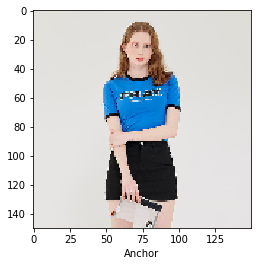

---------------similar item no.1-----------------


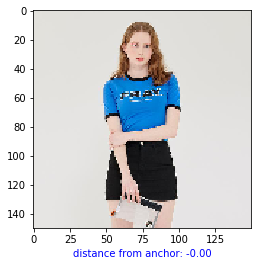

---------------similar item no.2-----------------


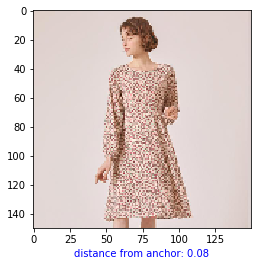

---------------similar item no.3-----------------


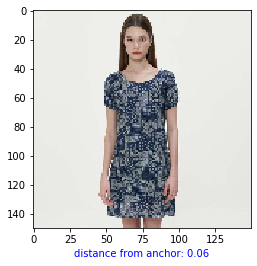

Found 3 similar items


In [24]:
thresh = 0.1

anchor = images[0]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

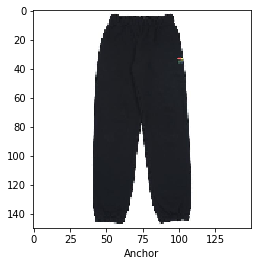

---------------similar item no.1-----------------


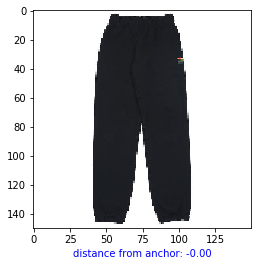

---------------similar item no.2-----------------


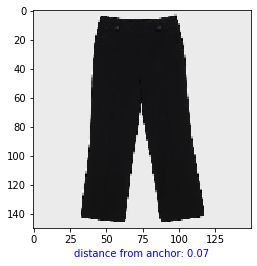

---------------similar item no.3-----------------


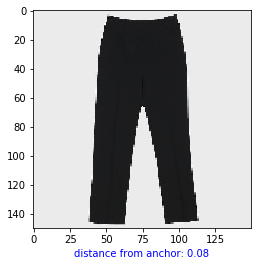

---------------similar item no.4-----------------


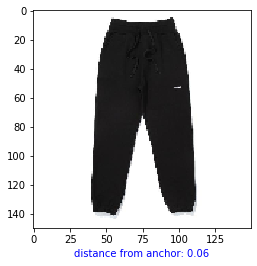

---------------similar item no.5-----------------


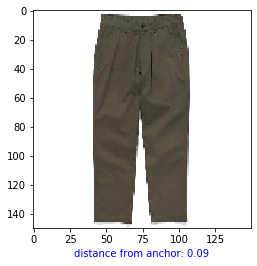

---------------similar item no.6-----------------


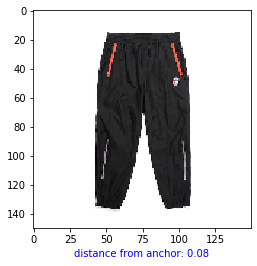

---------------similar item no.7-----------------


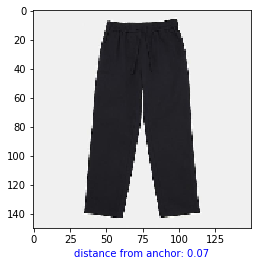

---------------similar item no.8-----------------


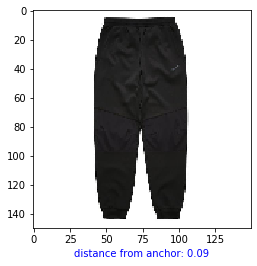

---------------similar item no.9-----------------


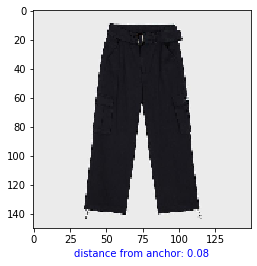

---------------similar item no.10-----------------


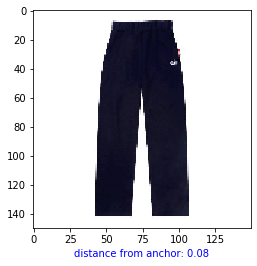

---------------similar item no.11-----------------


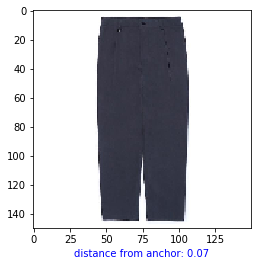

---------------similar item no.12-----------------


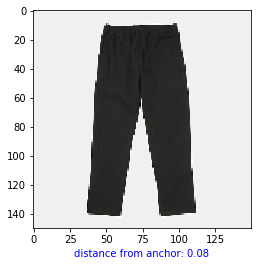

---------------similar item no.13-----------------


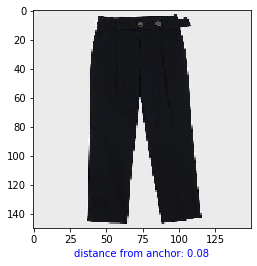

---------------similar item no.14-----------------


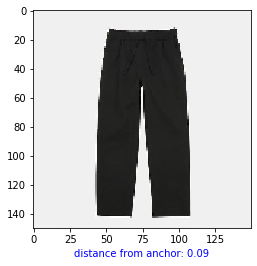

---------------similar item no.15-----------------


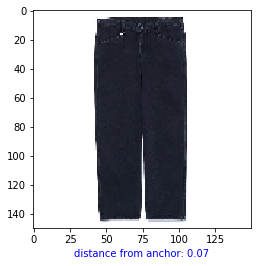

---------------similar item no.16-----------------


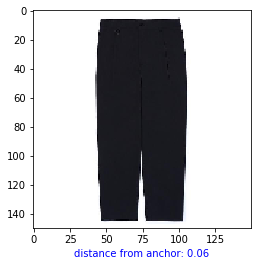

---------------similar item no.17-----------------


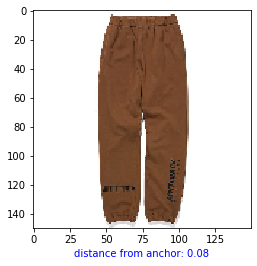

---------------similar item no.18-----------------


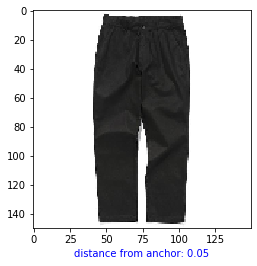

---------------similar item no.19-----------------


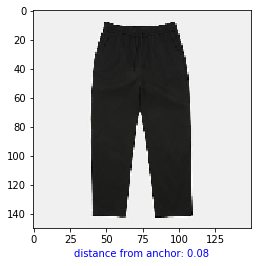

---------------similar item no.20-----------------


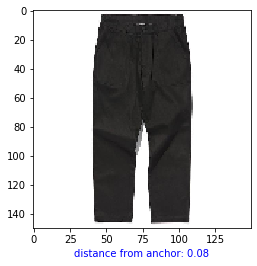

---------------similar item no.21-----------------


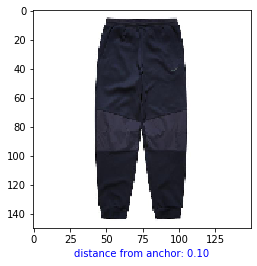

---------------similar item no.22-----------------


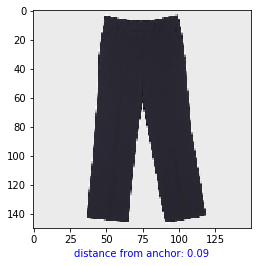

---------------similar item no.23-----------------


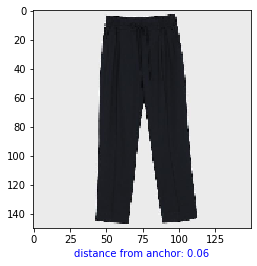

Found 23 similar items


In [25]:
thresh = 0.1

anchor = images[1]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

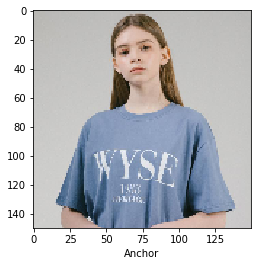

---------------similar item no.1-----------------


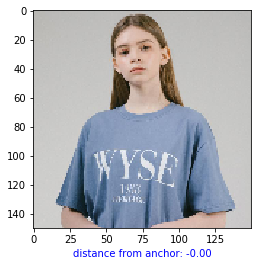

---------------similar item no.2-----------------


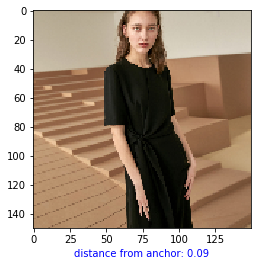

---------------similar item no.3-----------------


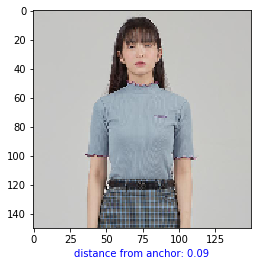

---------------similar item no.4-----------------


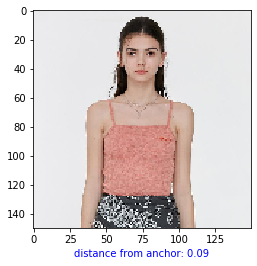

---------------similar item no.5-----------------


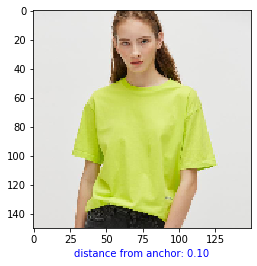

---------------similar item no.6-----------------


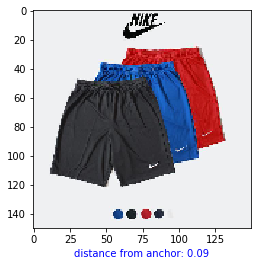

Found 6 similar items


In [26]:
thresh = 0.1

anchor = images[2]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

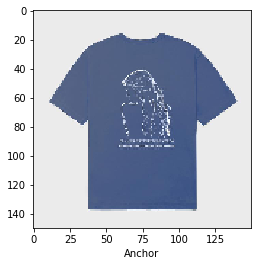

---------------similar item no.1-----------------


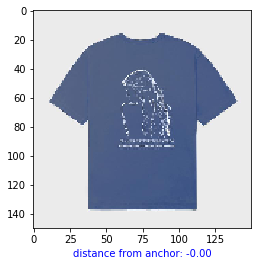

Found 1 similar items


In [27]:
thresh = 0.1

anchor = images[3]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

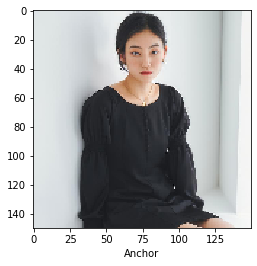

---------------similar item no.1-----------------


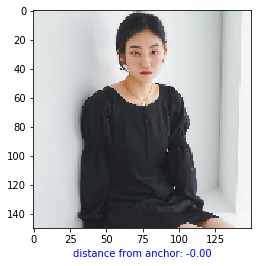

---------------similar item no.2-----------------


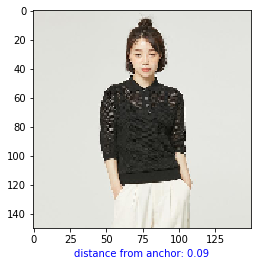

---------------similar item no.3-----------------


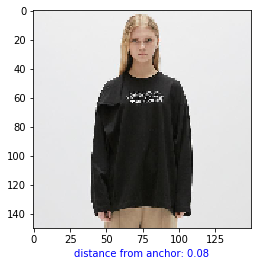

---------------similar item no.4-----------------


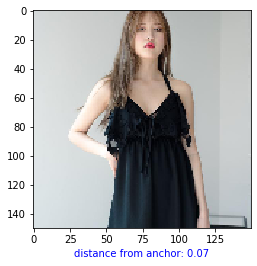

---------------similar item no.5-----------------


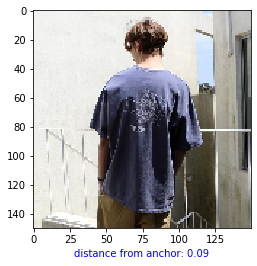

---------------similar item no.6-----------------


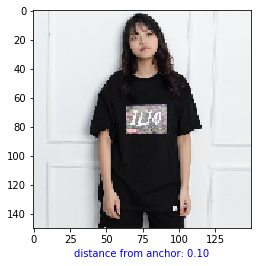

---------------similar item no.7-----------------


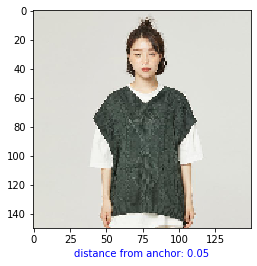

---------------similar item no.8-----------------


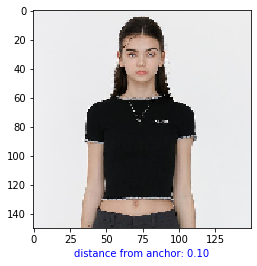

---------------similar item no.9-----------------


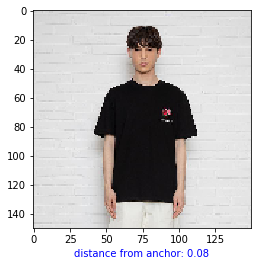

---------------similar item no.10-----------------


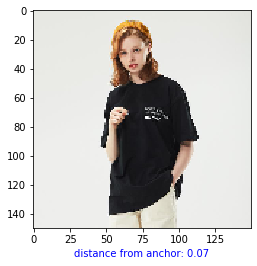

---------------similar item no.11-----------------


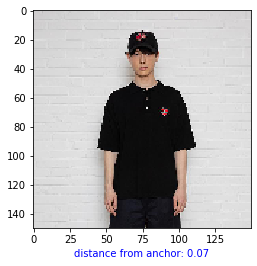

---------------similar item no.12-----------------


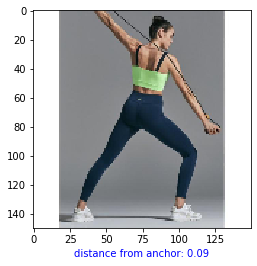

---------------similar item no.13-----------------


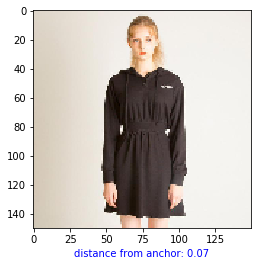

---------------similar item no.14-----------------


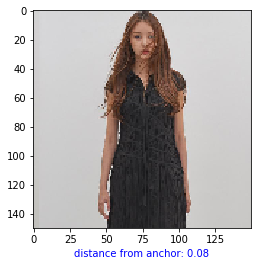

---------------similar item no.15-----------------


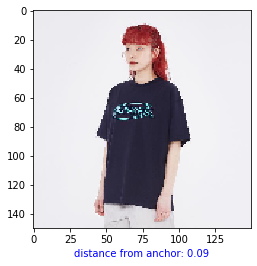

---------------similar item no.16-----------------


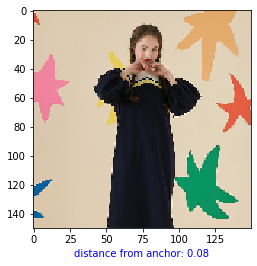

---------------similar item no.17-----------------


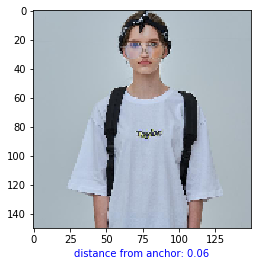

---------------similar item no.18-----------------


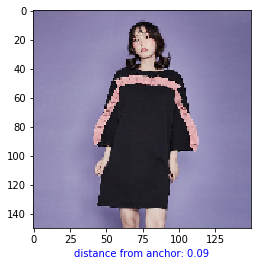

---------------similar item no.19-----------------


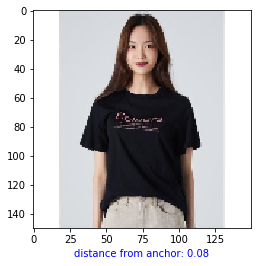

---------------similar item no.20-----------------


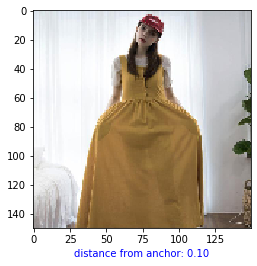

---------------similar item no.21-----------------


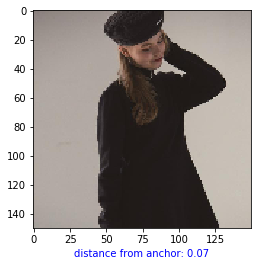

---------------similar item no.22-----------------


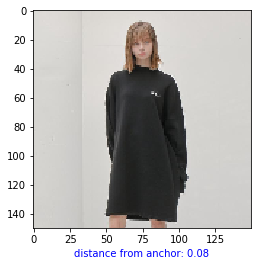

---------------similar item no.23-----------------


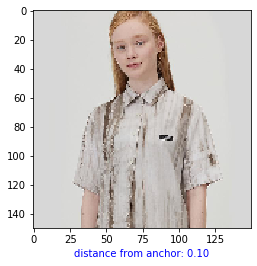

---------------similar item no.24-----------------


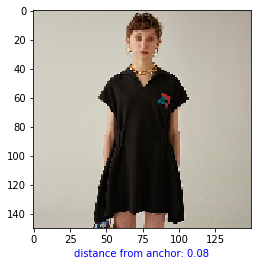

---------------similar item no.25-----------------


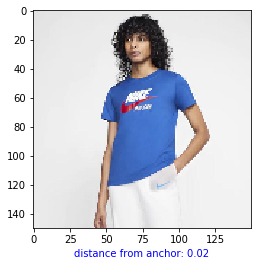

Found 25 similar items


In [28]:
thresh = 0.1

anchor = images[4]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

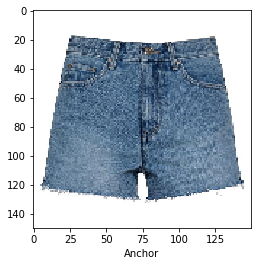

---------------similar item no.1-----------------


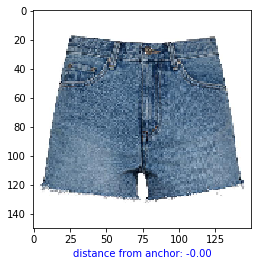

---------------similar item no.2-----------------


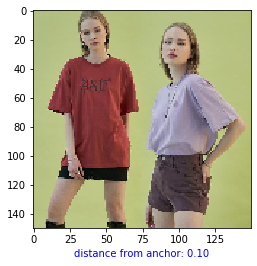

---------------similar item no.3-----------------


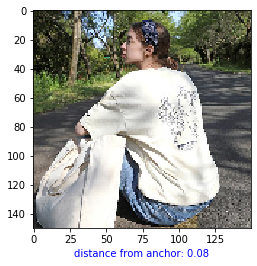

Found 3 similar items


In [29]:
thresh = 0.1

anchor = images[5]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, abase_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

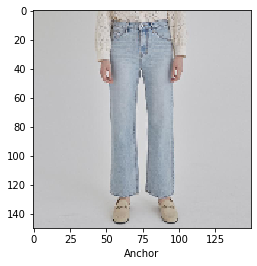

---------------similar item no.1-----------------


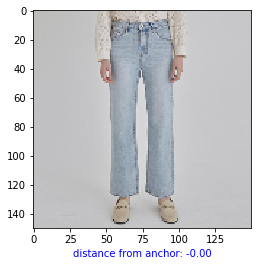

---------------similar item no.2-----------------


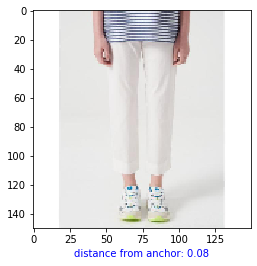

---------------similar item no.3-----------------


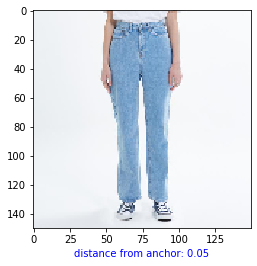

---------------similar item no.4-----------------


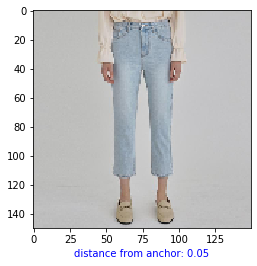

---------------similar item no.5-----------------


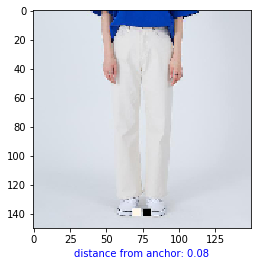

---------------similar item no.6-----------------


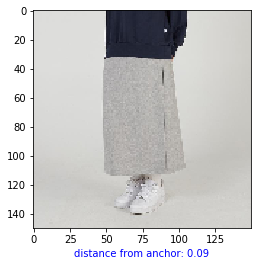

---------------similar item no.7-----------------


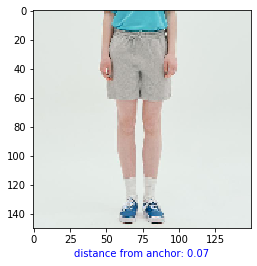

---------------similar item no.8-----------------


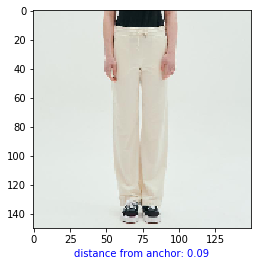

---------------similar item no.9-----------------


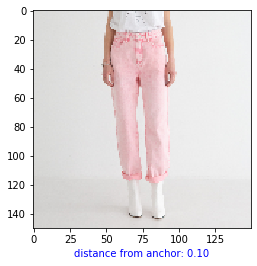

---------------similar item no.10-----------------


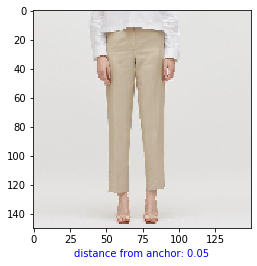

---------------similar item no.11-----------------


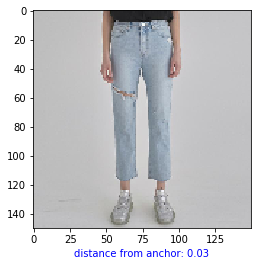

---------------similar item no.12-----------------


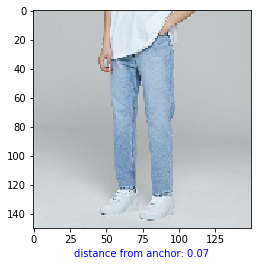

---------------similar item no.13-----------------


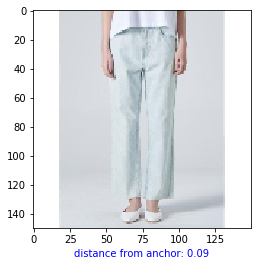

---------------similar item no.14-----------------


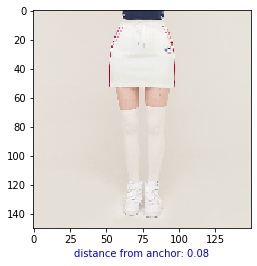

---------------similar item no.15-----------------


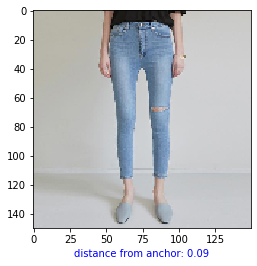

---------------similar item no.16-----------------


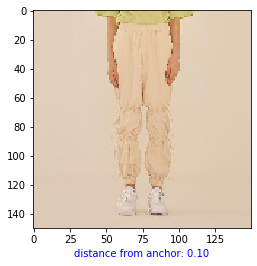

---------------similar item no.17-----------------


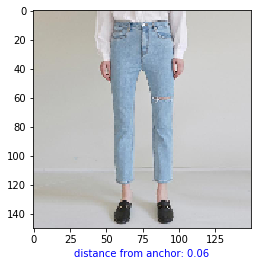

---------------similar item no.18-----------------


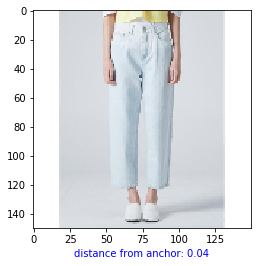

---------------similar item no.19-----------------


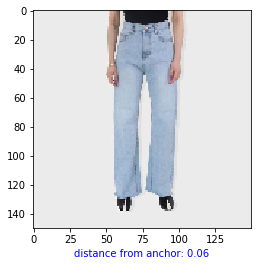

---------------similar item no.20-----------------


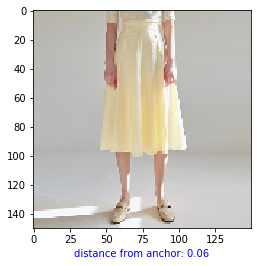

---------------similar item no.21-----------------


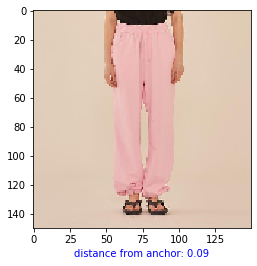

---------------similar item no.22-----------------


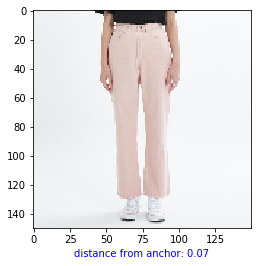

---------------similar item no.23-----------------


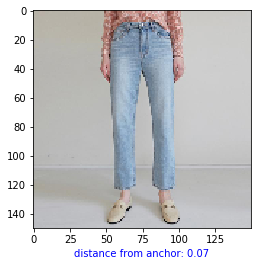

---------------similar item no.24-----------------


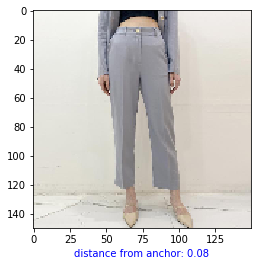

---------------similar item no.25-----------------


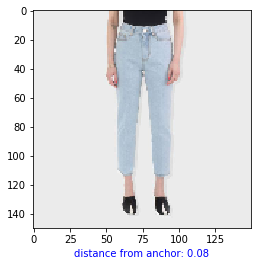

---------------similar item no.26-----------------


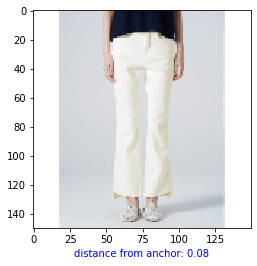

Found 26 similar items


In [31]:
thresh = 0.1

anchor = images[6]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

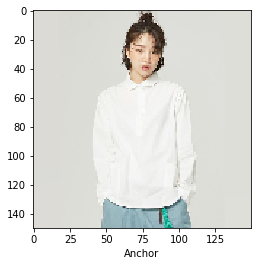

---------------similar item no.1-----------------


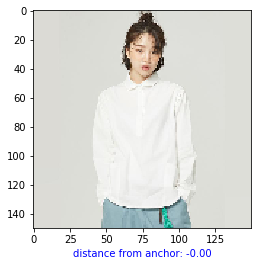

---------------similar item no.2-----------------


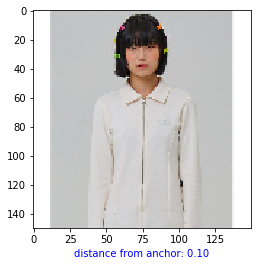

---------------similar item no.3-----------------


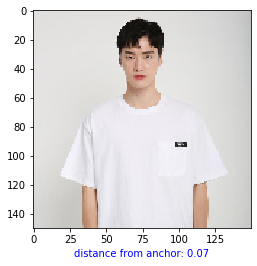

---------------similar item no.4-----------------


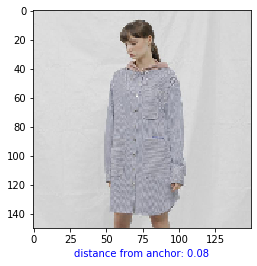

---------------similar item no.5-----------------


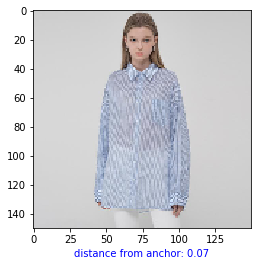

---------------similar item no.6-----------------


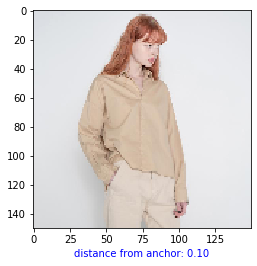

---------------similar item no.7-----------------


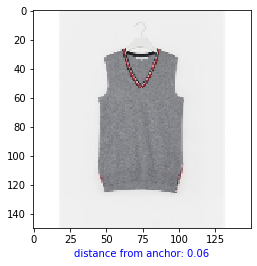

---------------similar item no.8-----------------


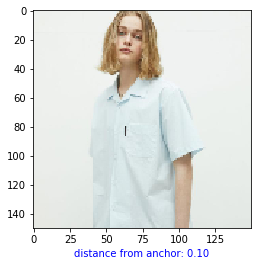

---------------similar item no.9-----------------


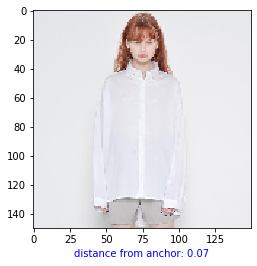

---------------similar item no.10-----------------


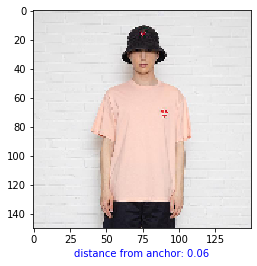

---------------similar item no.11-----------------


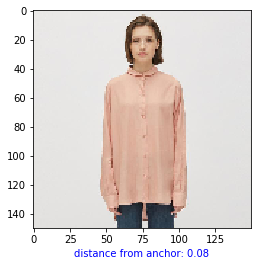

---------------similar item no.12-----------------


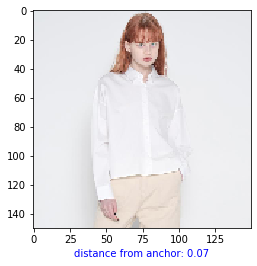

---------------similar item no.13-----------------


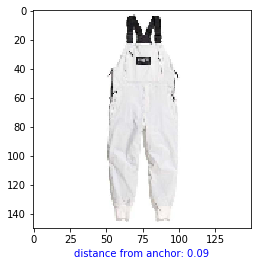

---------------similar item no.14-----------------


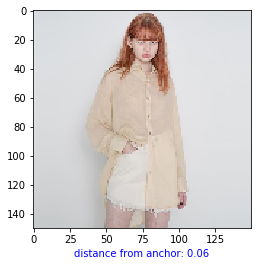

---------------similar item no.15-----------------


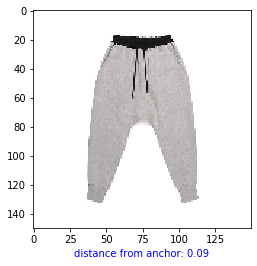

---------------similar item no.16-----------------


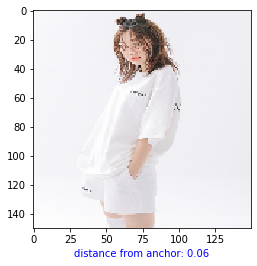

---------------similar item no.17-----------------


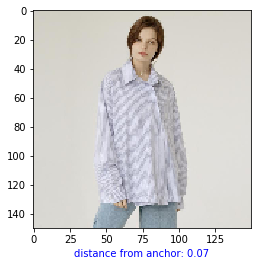

---------------similar item no.18-----------------


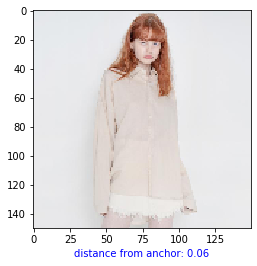

---------------similar item no.19-----------------


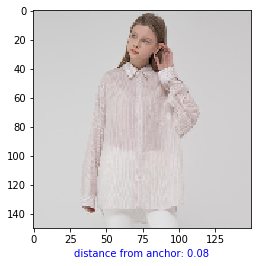

---------------similar item no.20-----------------


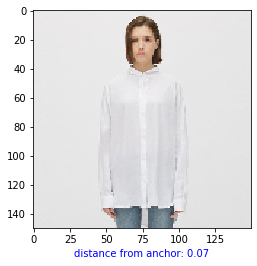

---------------similar item no.21-----------------


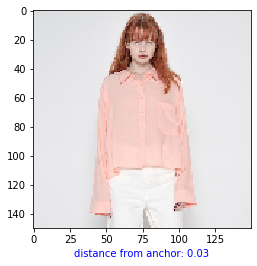

---------------similar item no.22-----------------


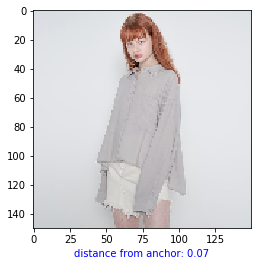

---------------similar item no.23-----------------


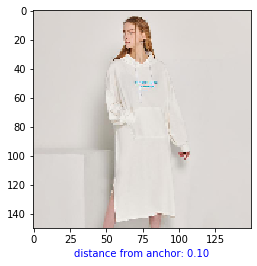

---------------similar item no.24-----------------


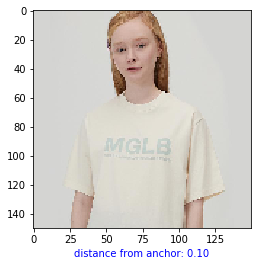

---------------similar item no.25-----------------


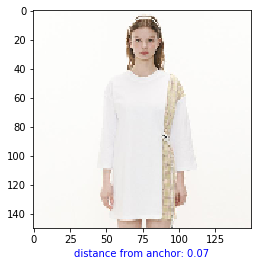

---------------similar item no.26-----------------


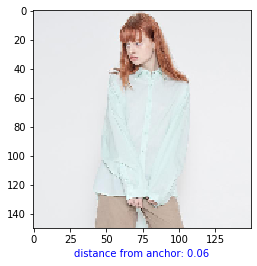

---------------similar item no.27-----------------


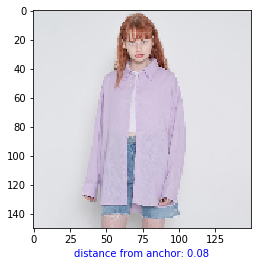

---------------similar item no.28-----------------


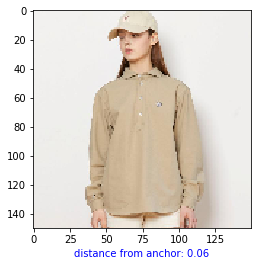

---------------similar item no.29-----------------


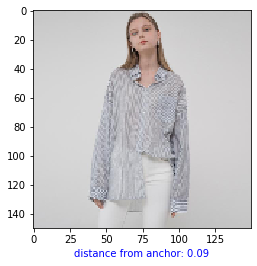

---------------similar item no.30-----------------


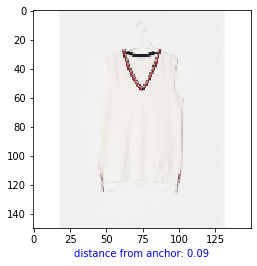

---------------similar item no.31-----------------


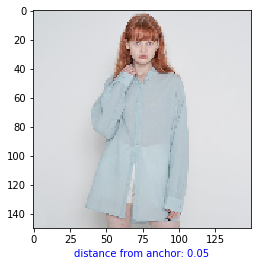

---------------similar item no.32-----------------


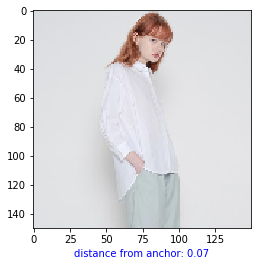

---------------similar item no.33-----------------


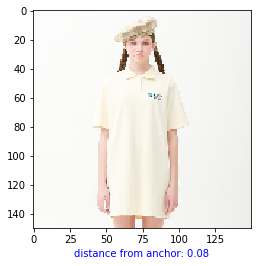

---------------similar item no.34-----------------


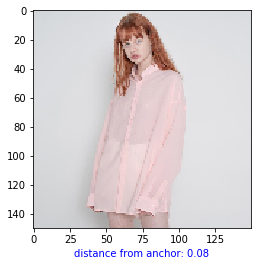

---------------similar item no.35-----------------


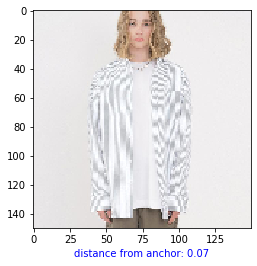

---------------similar item no.36-----------------


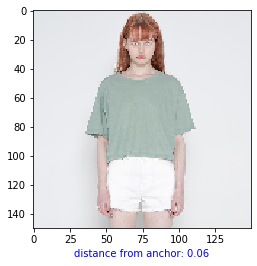

---------------similar item no.37-----------------


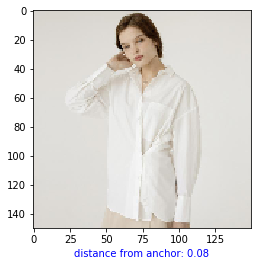

---------------similar item no.38-----------------


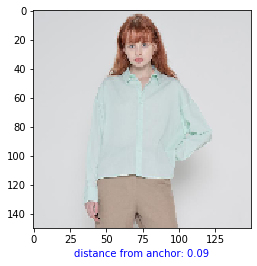

---------------similar item no.39-----------------


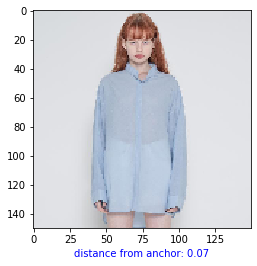

---------------similar item no.40-----------------


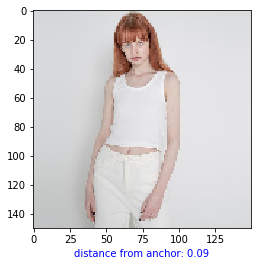

---------------similar item no.41-----------------


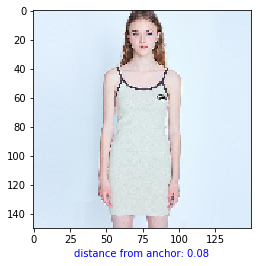

---------------similar item no.42-----------------


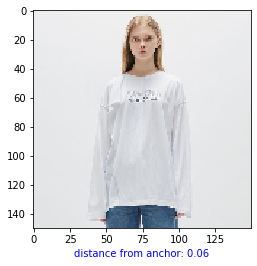

---------------similar item no.43-----------------


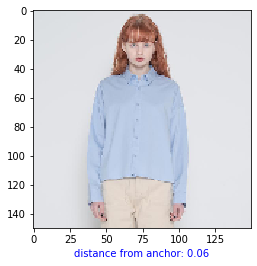

---------------similar item no.44-----------------


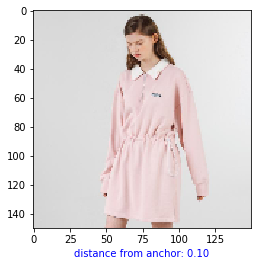

---------------similar item no.45-----------------


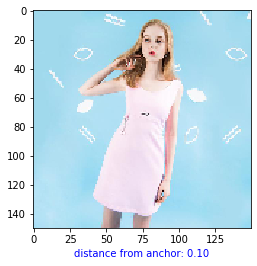

---------------similar item no.46-----------------


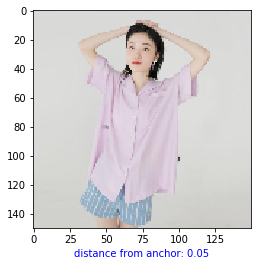

---------------similar item no.47-----------------


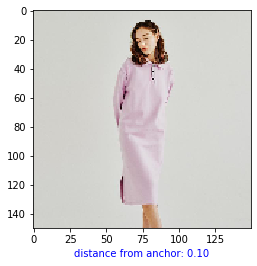

---------------similar item no.48-----------------


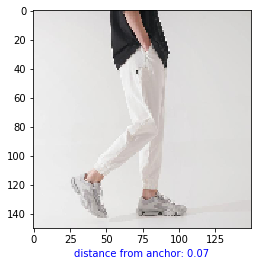

---------------similar item no.49-----------------


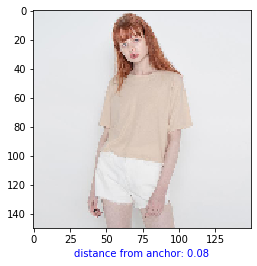

---------------similar item no.50-----------------


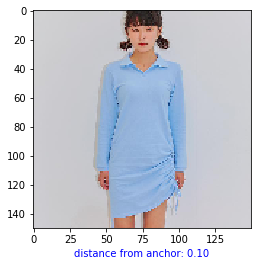

---------------similar item no.51-----------------


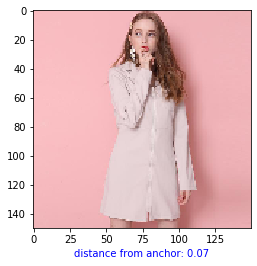

---------------similar item no.52-----------------


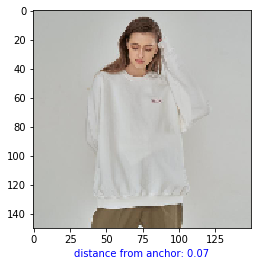

---------------similar item no.53-----------------


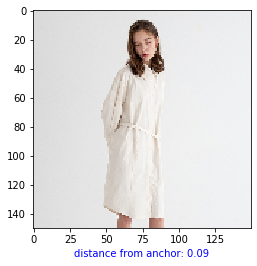

---------------similar item no.54-----------------


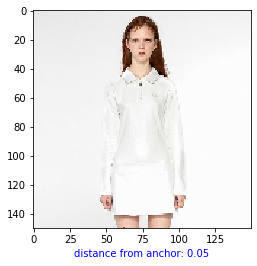

---------------similar item no.55-----------------


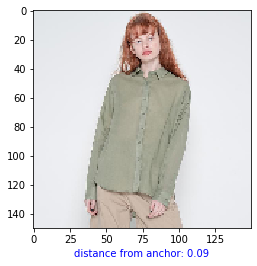

---------------similar item no.56-----------------


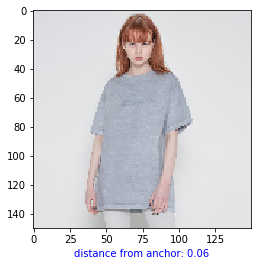

---------------similar item no.57-----------------


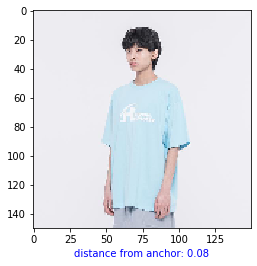

Found 57 similar items


In [32]:
thresh = 0.1

anchor = images[7]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

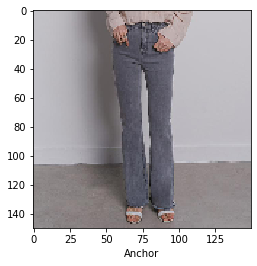

---------------similar item no.1-----------------


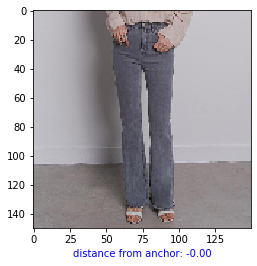

---------------similar item no.2-----------------


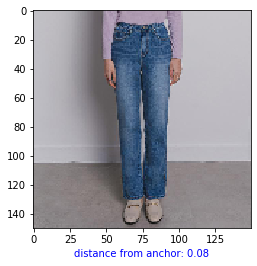

Found 2 similar items


In [33]:
thresh = 0.1

anchor = images[8]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))

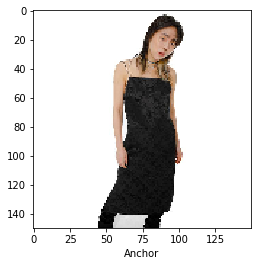

---------------similar item no.1-----------------


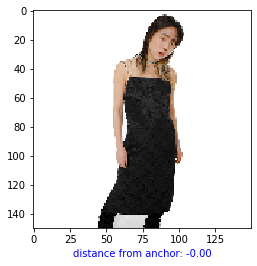

---------------similar item no.2-----------------


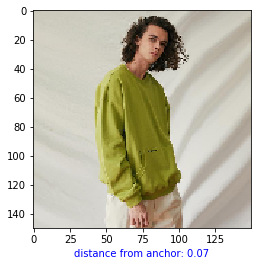

---------------similar item no.3-----------------


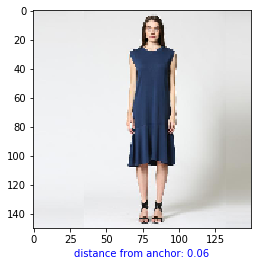

---------------similar item no.4-----------------


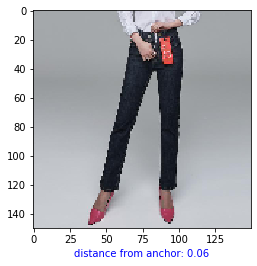

---------------similar item no.5-----------------


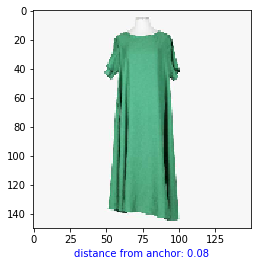

---------------similar item no.6-----------------


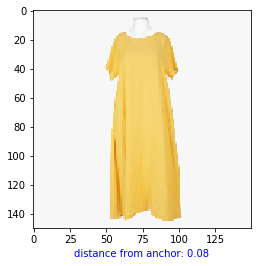

---------------similar item no.7-----------------


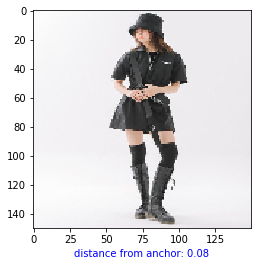

---------------similar item no.8-----------------


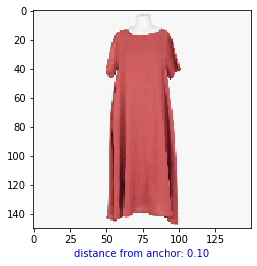

---------------similar item no.9-----------------


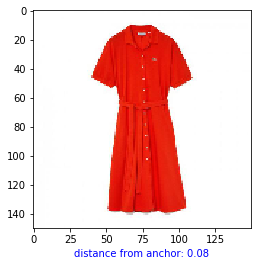

Found 9 similar items


In [34]:
thresh = 0.1

anchor = images[9]
anchor_encoding = item_to_encoding(anchor, base_network)
test_size = images.shape[0]

plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor")
plt.show()

sim_count = 0

for image in images:          
    item_encoding = item_to_encoding(image, base_network)
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    if dist < thresh:
        sim_count += 1
        print('---------------similar item no.{}-----------------'.format(sim_count))
        plt.imshow(image, cmap = 'gray')
        plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = "blue")
        plt.show()

print("Found {} similar items".format(sim_count))